# Proyecto Final: Modelos de Hielo

Luis Alemán
\\ Jorge Ramírez

- Computacionalmente, el hielo ha sido estudiado desde los 60's por ser algo común y el tamaño de sus constituyentes era suficientemente pequeño (o grande) para ser estudiado numéricamente desde las primeras computadoras. 

- Desde el final del siglo XIX, se sabía que la estructura de los copos de nieve era hexagonal. No fue hasta 1929 hasta que se descubrió que es la estructura del hielo $I_h$ a presión normal.
- Después de más experimentos de difracción, se dedujo que los oxígenos formaban una red y los hidrógenos no se acomodaban en una red determinada. Más tarde se descubrió que los hidrógenos no se acomodan a la mitad entre dos oxígenos, sino que cada uno de ellos se mantiene cerca de un oxígeno en particular. Además, dos y sólo dos hidrógenos están asociados a cada oxígeno, de manera que la estructura de las moléculas de agua como unidades estructurales se preserva.

- Desde 1933 se intentó predecir arreglos de los hidrógenos, sin encontrar alguna que coincidiera con que no se formaran super-redes de hidrógenos.
- Reglas del hielo:
 1. Hay sola y necesariamente un hidrógeno en cada puente de hidrógeno.
 2. Hay exactamente dos iones hidrógeno asociados a cada oxígeno.

<img src="6config.png">

Existen muchos modelos para comprender la estructura del hielo. Durante este notebook trabajaremos con hielo "cuadrado", es decir, una red cuadrada de iones de oxígeno que están unidos por puentes de hidrógeno. Los grados de libertad con los que trabajaremos serán las posiciones de equilibrio de los iones de hidrógeno.

En 1962, Lennard planteó una bonita manera de tratar equivalentemente con este modelo de flechas, el modelo de 3 colores.
<img src="3colores.png" width=400>

###Algoritmo para modelo de 3 colores:
1. Escogemos al azar un sitio de toda la red como semilla de nuestro cluster. Este sitio tiene color A.
2. Escogemos al azar un segundo color de las otras dos posibilidades, lo llamamos color B.
3. Empezando de nuestra semilla, formamos un cluster de sitios añadiendo todos los primeros vecinos que tengan color A o color B. Paramos hasta que todos los primeros vecinos de la frontera de nuestro cluster sean color C.
4. Los colores A y B de todos los sitios del cluster son intercambiados.

####Balance detallado
Consideramos un movimiento de un estado $\mu$ a un estado $\nu$, el cual involucra un cluster de m sitios. La probabilidad de ir tomar la semilla dentro de este cluster es $m/N$. La probabilidad de escoger a un color B es $1/2$. No hay más decisiones. Por lo tanto P($\mu \rightarrow \nu)=P(\nu \rightarrow \mu$).

####Ergodicidad
Cada estado de nuestra red puede descomponerse en regiones AB rodeadas de C. Gracias al algoritmo, estas regiones AB pueden crecer o disminuir. Debido a la elección al azar, podemos llegar a un estado de la red completamente AB en un número finito de pasos. Además, estos pasos son reversibles. Hay 6 distintos estados de la red completamente AB y se puede llegar de uno a otro en un número finito de pasos (basta cambiar el color de uno solo por C, el otro no se afecta).

In [1]:
using Hielo

In [2]:
using PyPlot

INFO: Loading help data...


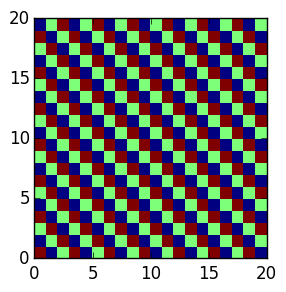

PyObject <matplotlib.collections.QuadMesh object at 0x7fb60e290d90>

In [7]:
diagonales=conf_i(20,20)
fig=figure(figsize=[3,3])
pcolormesh(diagonales)

##Nuestro algoritmo:

In [ ]:
function Single_cluster(arreglo::Array{Float64,2})
    L2=length(arreglo[1,:])
    L1=length(arreglo[:,1])
    red_bool=trues(L1,L2)
    #Se escoge un cuadrado al azar entre toda la red, y su número es 'colorA'
    i=rand(1:L1)
    j=rand(1:L2)
    colorA=arreglo[i,j]
    #Se escoge al azar un 'colorB' entre los restantes
    colorB=mod(rand(colorA+1:colorA+2),3)
    index_i=[i]
    index_j=[j]
    #Cambio el color de la celda inicial
    arreglo[i,j]=colorB
    red_bool[i,j]=false
    test=false
    t_limit=L1*2
    t=1
    while t<t_limit
        new_index_i=Int[]
        new_index_j=Int[]
        for n=1:length(index_i)
            #Primeros vecinos
            for ij=1:4
                inew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[1]
                jnew=indices_primeros(ij,index_i[n],index_j[n],L1,L2)[2]
                if red_bool[inew,jnew]==true
                    if arreglo[inew,jnew]==colorA
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorB
                        test=true
                    elseif arreglo[inew,jnew]==colorB
                        push!(new_index_i,inew)
                        push!(new_index_j,jnew)
                        red_bool[inew,jnew]=false
                        arreglo[inew,jnew]=colorA
                        test=true
                    end
                end
            end
        end
        index_i=deepcopy(new_index_i)
        index_j=deepcopy(new_index_j)
        if test==false
            t=t_limit
        end
        test=false
    end
    return arreglo
end

###Probamos nuestro algoritmo:

In [3]:
singlehey=copy(diagonales)
@time for t in 1:1000
    shey_new=Single_cluster(singlehey)
    shey_new,singlehey=singlehey,shey_new
end
figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(diagonales)

subplot(1,2,2)
pcolormesh(singlehey)

LoadError: diagonales not defined
while loading In[3], in expression starting on line 1

También se puede hacer un algoritmo que involucre a toda la red. Esto es, escoger el color A y el B al azar, buscar todos los clusters que se forman con estos colores, pero ahora se le da una probabilidad de 1/2 de cambiar A por B en cada cluster.

#Energías

Existen muchos modelos energéticos para el arreglo de los Hidrógenos en los Oxígenos. Trabajaremos con el modelo $F$ que favorece los arreglos simétricos. 

$$H=-\epsilon \sum \limits_{i}(\delta_{v_i,5} + \delta_{v_i,6})$$

Para el modelo de 3 colores, esto se traduce en parejas de segundos vecinos (diagonales) del mismo color. El hamiltoniano se transforma entonces:
$$H=-\epsilon \sum \limits_{[i,j]}(\delta_{c_ic_j} - \frac{1}{2})=N\epsilon - \epsilon \sum \limits_{[i,j]}\delta_{c_ic_j}$$

El algoritmo entonces para crear clusters que favorezcan parejas de segundos vecinos del mismo color dependiente de la temperatura será:
1. Escogemos un cuadro de toda la red como semilla de nuestro cluster. Este cuadro tiene color A.
2. Escogemos un segundo color de las otras dos posibilidades, lo llamamos color B.
3. Empezando de nuestra semilla, formamos un cluster de cuadros añadiendo todos los primeros vecinos que tengan color A o color B, pero además ahora incluiremos con probablidad $P_{add}(T)$ a los segundos vecinos del cuadro $i$ que ya está en el cluster con la condición que tengan el mismo color que $i$.
4. Los colores A y B de todos los cuadros del cluster son intercambiados.

Para cononcer esta $P_{add}(T)$, hacemos que nuestro algoritmo cumpla balance detallado.

Consideramos 2 estados $\mu$ y $\nu$ que difieren por el intercambio de colores en un solo cluster de $m$ sitios. La probabilidad de escoger el cuadro inicial dentro del cluster es $m/N$ y $1/2$ la de escoger el color B. 

Ahora tenemos que tomar en cuenta el factor$P_{add}$ para cada sitio que queremos añadir al cluster que es segundo vecino de uno dentro. Además tenemos $1-P_{add}$ para cada sitio que pudimos agregar pero no lo hicimos.

Por lo tanto,

$$P(\mu\rightarrow\nu)=\frac{m}{2N}\prod_{[i,j]}_{con}P_{add}\prod_{[i,j]}_{dis}(1-P_{add})^{\delta(c_i^{\mu},c_j^{\mu})}$$

Trabajamos con los logaritmos:

$$log(P(\mu\rightarrow\nu))=-log(\frac{m}{2N})+log(P_{add})\sum\limits_{[i,j]}_{con}1+log(1-P_{add})\sum\limits_{[i,j]}_{dis}\delta(c_i^{\mu},c_j^{\mu})$$
 
Y por lo tanto,
$$log(\frac{P(\mu\rightarrow\nu))}{P(\nu\rightarrow\mu))}=log(1-P_{add})\sum\limits_{[i,j]}_{dis}[\delta(c_i^{\mu},c_j^{\mu})-\delta(c_i^{\nu},c_j^{\nu})]$$

A su vez, queremos que 

$$log(\frac{P(\mu\rightarrow\nu))}{P(\nu\rightarrow\mu))}=-\beta \Delta E$$

$$\Delta E=E(\nu)-E(\mu)=\epsilon\sum\limits_{[i,j]}[\delta(c_i^{\mu},c_j^{\mu})-\delta(c_i^{\nu},c_j^{\nu})]$$

Y, por lo tanto,

$$P_{add}=1-e^{-\beta \epsilon}$$

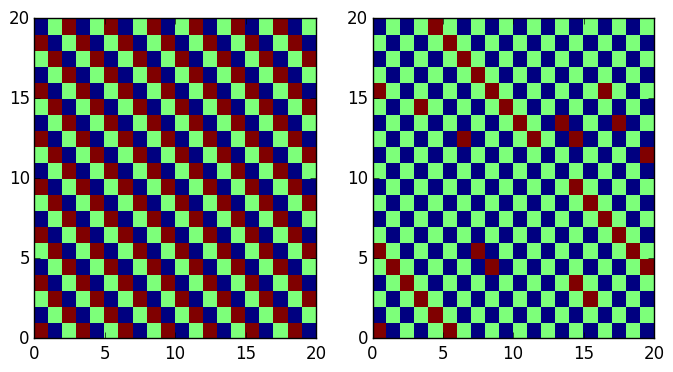

PyObject <matplotlib.collections.QuadMesh object at 0x7f08718e3ed0>

In [4]:
inicial_s=conf_i(20,20)
old_s=copy(inicial_s)
for t in 1:10
    new=Single_cluster_E(1.0,old_s)
    new,old_s=old_s,new
end
figure(figsize=[8,4])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial_s)

subplot(1,2,2)
pcolormesh(old_s)

Hacemos una función que nos cuente el número de segundos vecinos del mismo color

In [5]:
contador_segundos(inicial_s),contador_segundos(old_s)

(400.0,712.0)

In [6]:
old_s=copy(inicial_s)
betas=[i*0.2 for i in 0:20]
out=zeros(length(betas))
@time for i in 1:length(betas)
    for t in 1:100
        new=Single_cluster_E(betas[i],old_s)
        old_s,new=new,old_s
    end
    out[i]=contador_segundos(old_s)
end

elapsed time: 7.422381799 seconds (839445248 bytes allocated, 19.02% gc time)


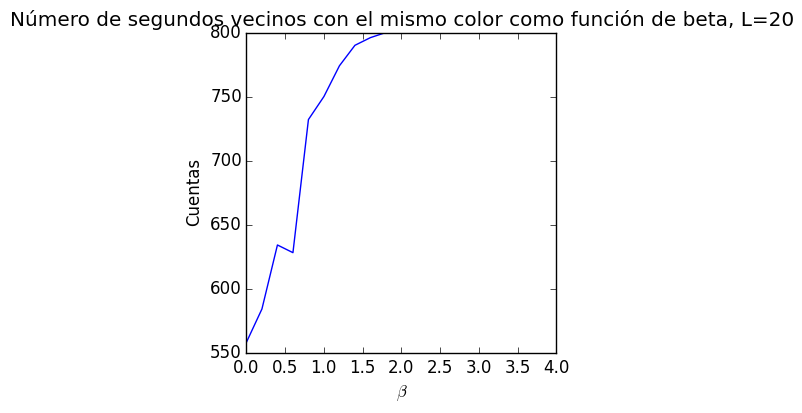

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f085763fc50>

In [7]:
figure(figsize=[4,4])
title("Número de segundos vecinos con el mismo color como función de beta, L=20")
xlabel(L"$\beta$")
ylabel("Cuentas")
plot(betas,out)

####A medida que la temperatura baja, vemos que es más fácil aceptar los cambios y el número de segundos vecinos con el mismo color tiende a su máximo de 2N.

Implementamos el método de muchos clusters (MultiCluster), que según la bibliografía es más rápido.

####Si se usara como distribución inicial la de las diagonales,

In [8]:
inicial_m=conf_i(20,20);

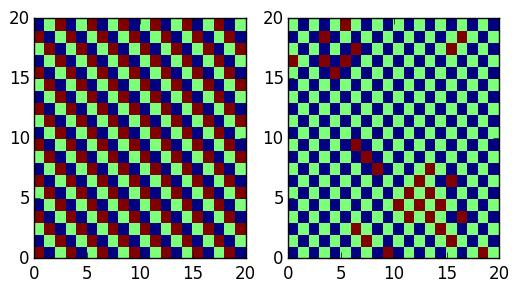

PyObject <matplotlib.collections.QuadMesh object at 0x7f0856d6ec50>

In [9]:
old_m=copy(inicial_m)
for t in 1:30
    new=MultiCluster_E(1.0,old_m)
    new,old_m=old_m,new
end
figure(figsize=[6,3])
subplot(1,2,1)
#figure(figsize=[3,3])
pcolormesh(inicial_m)

subplot(1,2,2)
pcolormesh(old_m)

####Si se usara como distribución inicial una distribución arrojada por el método de Single Cluster sin energía,

In [3]:
inicial=conf_random(50,50,30);

In [4]:
old_m=copy(inicial)
@time for t in 1:30
    new=MultiCluster_E(1.0,old_m)
    new,old_m=old_m,new
end

elapsed time: 0.980331185 seconds (138974736 bytes allocated, 19.86% gc time)


In [5]:
@time old_s=copy(inicial)
for t in 1:30
    new=Single_cluster_E(1.0,old_s)
    new,old_s=old_s,new
end

elapsed time: 0.001292264 seconds (23040 bytes allocated)


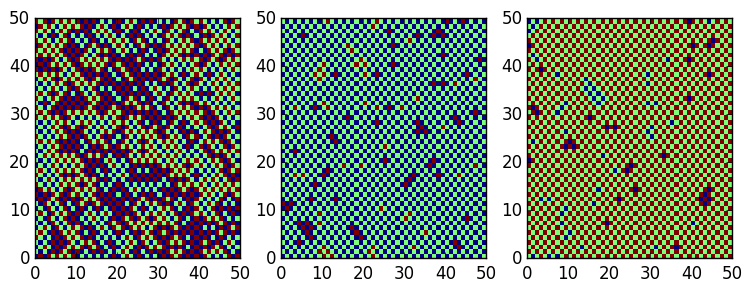

PyObject <matplotlib.collections.QuadMesh object at 0x7fe1071d6250>

In [6]:
figure(figsize=[9,3])
subplot(1,3,1)
#figure(figsize=[3,3])
pcolormesh(inicial)

subplot(1,3,2)
pcolormesh(old_s)

subplot(1,3,3)
pcolormesh(old_m)

In [7]:
contador_segundos(old_m), contador_segundos(old_s)

(4754.0,4662.0)

###La energía estará dada por el número de segundos vecinos del mismo color.

In [ ]:
function energiaspromedio_beta(configuracion_inicial::Array{Float64,2},β_max=5.0,t_max=50,intervalos=20)
    L1=length(configuracion_inicial[:,1])
    L2=length(configuracion_inicial[1,:])
    1-contadorespromedio_beta(configuracion_inicial::Array{Float64,2},β_max,t_max,intervalos)/(L1*L2)
end

elapsed time: 105.893559112 seconds (21317160008 bytes allocated, 30.86% gc time)


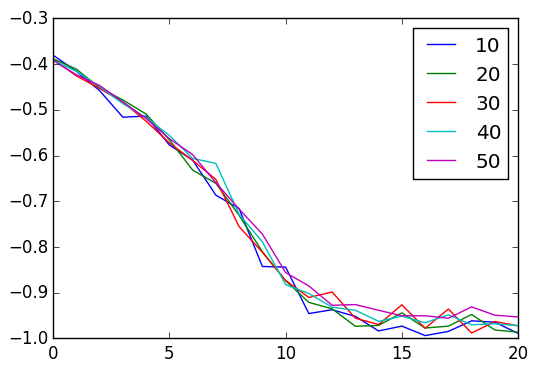

In [10]:
L_max=50
tamaños=[10:10:L_max]
maximo=length(tamaños)
figure(figsize=[6,4])
@time for i in 1:maximo
    config=conf_random(tamaños[i],tamaños[i],10)
    plot(energiaspromedio_beta(config,2.0,100),label=tamaños[i])
    legend()
end

elapsed time: 509.488688184 seconds (153958325496 bytes allocated, 52.63% gc time)


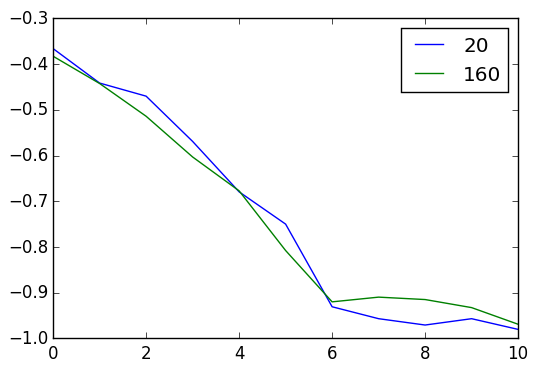

In [9]:
L_max=160
tamaños=[20,L_max]
maximo=length(tamaños)
out=zeros(maximo,21)
figure(figsize=[6,4])
@time for i in 1:maximo
    config=conf_random(tamaños[i],tamaños[i],10)
    plot(energiaspromedio_beta(config,2.0,100,10),label=tamaños[i])
    legend()
end